# Baseline

In [505]:
import os
import copy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

from argparse import Namespace

## 原始数据集

In [2]:
data_prefix = './data'
data_dev = os.path.join(data_prefix, 'dev.csv')
data_level_meta = os.path.join(data_prefix, 'level_meta.csv')
data_level_seq = os.path.join(data_prefix, 'level_seq.csv')
data_test = os.path.join(data_prefix, 'test.csv')
data_train = os.path.join(data_prefix, 'train.csv')

In [3]:
raw_level_seq_df = pd.read_csv(data_level_seq, sep='\t')
raw_level_meta_df = pd.read_csv(data_level_meta, sep='\t')
raw_train_df = pd.read_csv(data_train, sep='\t')
raw_dev_df = pd.read_csv(data_dev, sep='\t')
raw_test_df = pd.read_csv(data_test)

训练集、验证机和测试集样本数量，`user_id`分布

In [4]:
len(raw_train_df), len(raw_dev_df), len(raw_test_df),

(8158, 2658, 2773)

In [5]:
sum([len(raw_train_df), len(raw_dev_df), len(raw_test_df)])

13589

* 共`13589`个用户
* 训练集`user_id`分布 `2774 ~ 10931`，有标签
* 验证集`user_id`分布 `10932 ~ 13589`，有标签
* 测试集`user_id`分布 `1 ~ 2773`，无标签

In [6]:
raw_level_seq_df.head(5).T

,0,1,2,3,4
user_id,10932,10932,10932,10932,10932
level_id,1,2,3,4,5
f_success,1,1,1,1,1
f_duration,127,69,67,58,83
f_reststep,0.5,0.703704,0.56,0.7,0.666667
f_help,0,0,0,0,0
time,2020-02-01 00:05:51,2020-02-01 00:08:01,2020-02-01 00:09:50,2020-02-01 00:11:16,2020-02-01 00:13:12


* `user_id`：用户 id，和训练、验证、测试集中的可以匹配
* `level_id`：关卡 id
* `f_success`：是否通关（1：通关，0：失败）
* `f_duration`：此次尝试所用的时间（单位 s）
* `f_reststep`：剩余步数与限定步数之比（失败为 0）
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）
* `time`：时间戳

In [7]:
raw_level_meta_df.head(5).T

,0,1,2,3,4
f_avg_duration,39.889940,60.683975,76.947355,58.170347,101.784577
f_avg_passrate,0.944467,0.991836,0.991232,0.993843,0.954170
f_avg_win_duration,35.582757,56.715706,71.789943,54.842882,85.650547
f_avg_retrytimes,0.017225,0.004638,0.004480,0.004761,0.027353
level_id,1.000000,2.000000,3.000000,4.000000,5.000000


In [8]:
raw_level_meta_df.tail(5).T

,1504,1505,1506,1507,1508
f_avg_duration,594.878788,486.56250,325.968750,793.096774,423.406250
f_avg_passrate,0.453730,0.45418,0.573525,0.322684,0.461409
f_avg_win_duration,133.625000,115.90625,86.250000,164.000000,106.833333
f_avg_retrytimes,3.187500,3.21875,2.687500,5.419355,2.200000
level_id,1505.000000,1506.00000,1507.000000,1508.000000,1509.000000


* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配

通关序列数据

In [9]:
raw_level_seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


* `user_id` 用户ID
* `level_id` 关卡ID
* `f_success` 是否通关
* `f_duration` 此次尝试所用时间（单位：秒）
* `f_reststep` 剩余步数与限定步数之比（失败为0）
* `f_help` 是否使用道具
* `time` 时间戳

## 数据探索分析

level（关卡）数据特征

level概要信息

In [10]:
raw_level_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   f_avg_duration      1509 non-null   float64
 1   f_avg_passrate      1509 non-null   float64
 2   f_avg_win_duration  1509 non-null   float64
 3   f_avg_retrytimes    1509 non-null   float64
 4   level_id            1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.1 KB


* 共1509等级（关卡）
* 没有缺失数据

level数据分布

array([[<AxesSubplot:title={'center':'f_avg_duration'}>,
        <AxesSubplot:title={'center':'f_avg_passrate'}>],
       [<AxesSubplot:title={'center':'f_avg_win_duration'}>,
        <AxesSubplot:title={'center':'f_avg_retrytimes'}>]], dtype=object)

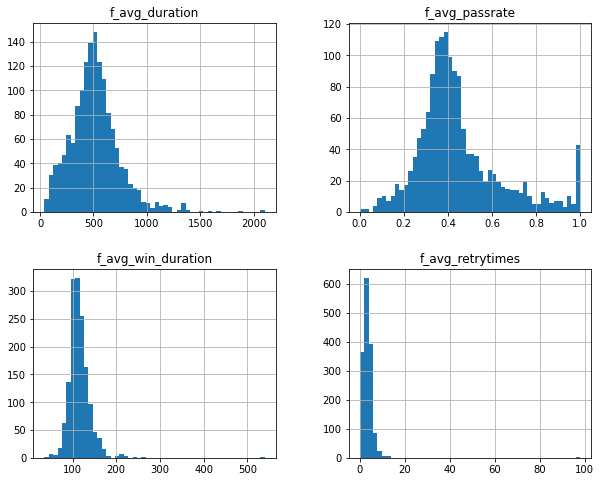

In [11]:
feats = ['f_avg_duration', 'f_avg_passrate', 'f_avg_win_duration', 'f_avg_retrytimes']
raw_level_meta_df[feats].hist(figsize=(10, 8), bins=50)

In [12]:
raw_level_meta_df[raw_level_meta_df.f_avg_retrytimes>20]

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
966,1003.0,0.021739,123.0,21.0,967
982,1128.0,0.000000,540.0,98.0,983
1014,1091.0,0.000000,540.0,98.0,1015


In [13]:
raw_level_meta_df[raw_level_meta_df.f_avg_win_duration>300]

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
982,1128.0,0.0,540.0,98.0,983
1014,1091.0,0.0,540.0,98.0,1015


`983`, `1015`数据可能是异常值

array([[<AxesSubplot:title={'center':'f_avg_duration'}>,
        <AxesSubplot:title={'center':'f_avg_passrate'}>],
       [<AxesSubplot:title={'center':'f_avg_win_duration'}>,
        <AxesSubplot:title={'center':'f_avg_retrytimes'}>]], dtype=object)

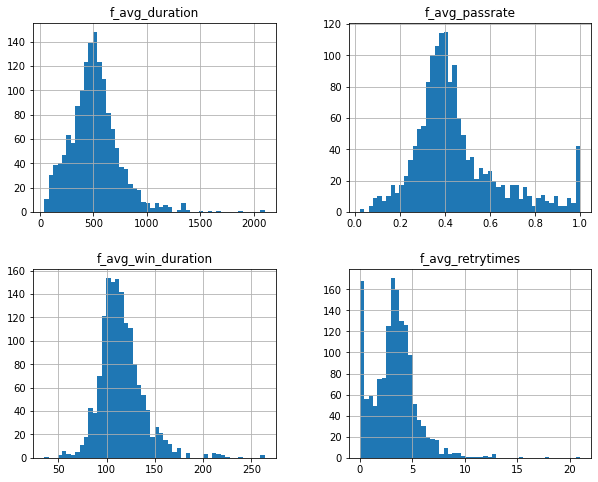

In [14]:
raw_level_meta_df[feats][~raw_level_meta_df.level_id.isin(['983', '1015'])].hist(figsize=(10, 8), bins=50)

level数据相关性

array([[<AxesSubplot:xlabel='f_avg_duration', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='f_avg_passrate', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='f_avg_win_duration', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='f_avg_retrytimes', ylabel='f_avg_duration'>,
        <AxesSubplot:xlabel='level_id', ylabel='f_avg_duration'>],
       [<AxesSubplot:xlabel='f_avg_duration', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='f_avg_passrate', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='f_avg_win_duration', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='f_avg_retrytimes', ylabel='f_avg_passrate'>,
        <AxesSubplot:xlabel='level_id', ylabel='f_avg_passrate'>],
       [<AxesSubplot:xlabel='f_avg_duration', ylabel='f_avg_win_duration'>,
        <AxesSubplot:xlabel='f_avg_passrate', ylabel='f_avg_win_duration'>,
        <AxesSubplot:xlabel='f_avg_win_duration', ylabel='f_avg_win_duration'>,
        <AxesSubplot:xlabel='f_avg_retrytimes'

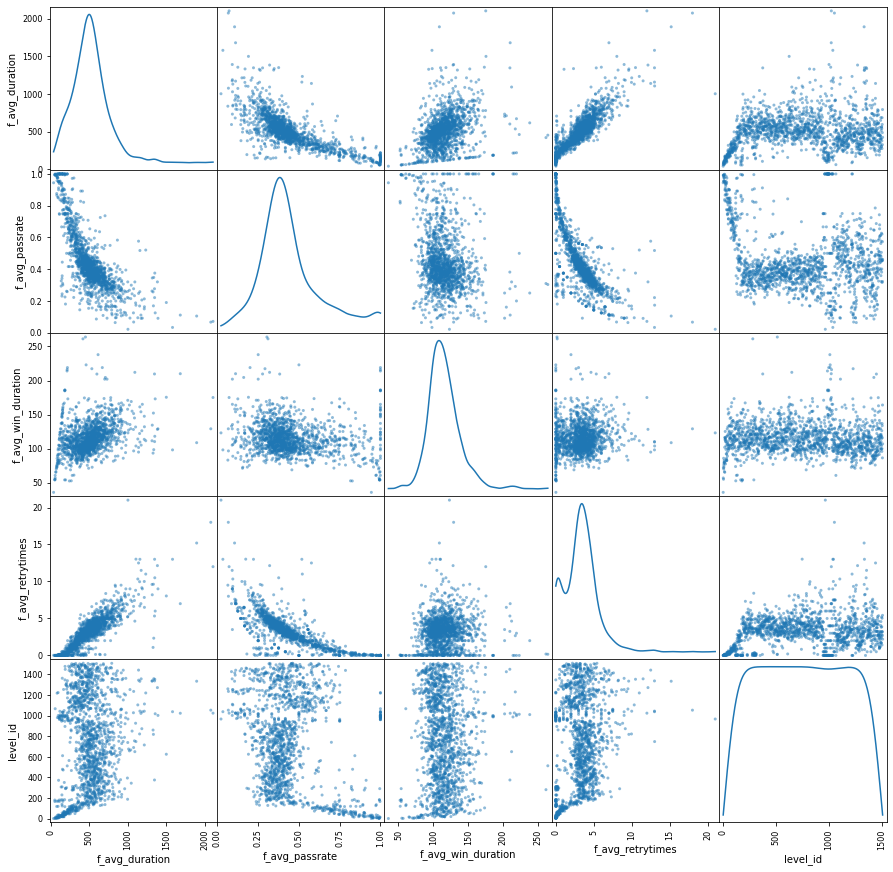

In [15]:
tmp_df = raw_level_meta_df[~raw_level_meta_df.level_id.isin(['983', '1015'])]
pd.plotting.scatter_matrix(tmp_df, figsize=(15, 15), diagonal='kde')

数据通关序列

In [16]:
raw_level_seq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194351 entries, 0 to 2194350
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     int64  
 1   level_id    int64  
 2   f_success   int64  
 3   f_duration  float64
 4   f_reststep  float64
 5   f_help      int64  
 6   time        object 
dtypes: float64(2), int64(4), object(1)
memory usage: 117.2+ MB


In [17]:
raw_level_seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


时间特征

In [18]:
time_series = raw_level_seq_df['time']
min(time_series), max(time_series)

('2020-02-01 00:00:20', '2020-02-04 23:59:59')

In [19]:
raw_level_seq_df[raw_level_seq_df.user_id==10931]

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
2194295,10931,1,1,28.0,0.500000,0,2020-02-02 00:01:33
2194296,10931,2,1,63.0,0.629630,0,2020-02-02 00:03:58
2194297,10931,3,1,61.0,0.400000,0,2020-02-02 00:05:39
2194298,10931,4,1,26.0,0.800000,0,2020-02-02 00:06:34
2194299,10931,5,0,129.0,0.000000,0,2020-02-02 00:09:14
2194300,10931,5,0,119.0,0.000000,0,2020-02-02 00:11:15
2194301,10931,5,1,87.0,0.583333,0,2020-02-02 00:12:44
2194302,10931,6,1,53.0,0.685714,0,2020-02-02 00:13:39
2194303,10931,7,1,98.0,0.500000,0,2020-02-02 00:16:12
2194304,10931,8,1,72.0,0.300000,0,2020-02-02 00:18:09


In [20]:
raw_train_df[raw_train_df.user_id==10931] 

,user_id,label
8157,10931,0


## 数据预处理和特征工程

合并训练、验证和测试集

In [141]:
raw_test_df['label'] = -1
df = pd.concat([raw_test_df, raw_train_df, raw_dev_df])
seq_df = copy.deepcopy(raw_level_seq_df)
meta_df = copy.deepcopy(raw_level_meta_df)

<AxesSubplot:>

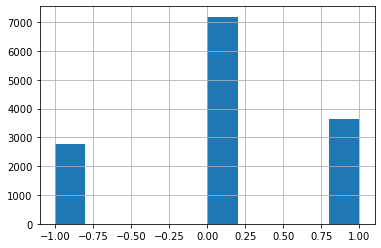

In [142]:
df['label'].hist()

In [143]:
df['label'].value_counts() / len(df.label)

 0    0.528736
 1    0.267201
-1    0.204062
Name: label, dtype: float64

In [144]:
seq_df['date_time'] =  pd.to_datetime(seq_df.time)
seq_df['tm_date'] = seq_df.date_time.dt.date
seq_df['tm_date_str'] = seq_df['tm_date'].astype('str')
seq_df['tm_day'] = seq_df.date_time.dt.day
seq_df['tm_hour'] = seq_df.date_time.dt.hour

In [145]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,date_time,tm_date,tm_date_str,tm_day,tm_hour
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,2020-02-01 00:05:51,2020-02-01,2020-02-01,1,0
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,2020-02-01 00:08:01,2020-02-01,2020-02-01,1,0
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,2020-02-01 00:09:50,2020-02-01,2020-02-01,1,0
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,2020-02-01 00:11:16,2020-02-01,2020-02-01,1,0
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,2020-02-01 00:13:12,2020-02-01,2020-02-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,2020-02-03 16:26:37,2020-02-03,2020-02-03,3,16
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,2020-02-03 16:28:06,2020-02-03,2020-02-03,3,16
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,2020-02-03 16:30:17,2020-02-03,2020-02-03,3,16
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,2020-02-03 16:33:40,2020-02-03,2020-02-03,3,16


In [146]:
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


### 特征工程

按天构建时序模型RNN

* 每天是否登录
* 每天最高等级
* 每天游戏时间
* 每天游戏次数
* 每天使用帮助次数

In [147]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,date_time,tm_date,tm_date_str,tm_day,tm_hour
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,2020-02-01 00:05:51,2020-02-01,2020-02-01,1,0
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,2020-02-01 00:08:01,2020-02-01,2020-02-01,1,0
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,2020-02-01 00:09:50,2020-02-01,2020-02-01,1,0
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,2020-02-01 00:11:16,2020-02-01,2020-02-01,1,0
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,2020-02-01 00:13:12,2020-02-01,2020-02-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,2020-02-03 16:26:37,2020-02-03,2020-02-03,3,16
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,2020-02-03 16:28:06,2020-02-03,2020-02-03,3,16
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,2020-02-03 16:30:17,2020-02-03,2020-02-03,3,16
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,2020-02-03 16:33:40,2020-02-03,2020-02-03,3,16


每天是否登录

In [148]:
tmp = seq_df.drop_duplicates(['user_id', 'tm_date'], keep='first')
tmp = tmp.pivot(index='user_id', columns='tm_date_str')['level_id']
tmp = tmp.fillna(0)
tmp = tmp.astype('bool').astype('int').reset_index()
tmp.columns = ['user_id'] + ['login_01', 'login_02', 'login_03', 'login_04']

In [149]:
df = df.merge(tmp, on='user_id', how='left')

每天最高等级

> 未玩游戏，值为昨天的等级

In [150]:
tmp = seq_df.drop_duplicates(['user_id', 'tm_date'], keep='last')
tmp = tmp.pivot(index='user_id', columns='tm_date_str')['level_id']
tmp = tmp.fillna(0).reset_index()
tmp.columns = ['user_id'] + ['level_01', 'level_02', 'level_03', 'level_04']

tmp['level_02'] = tmp[['level_01', 'level_02']].max(axis=1)
tmp['level_03'] = tmp[['level_02', 'level_03']].max(axis=1)
tmp['level_04'] = tmp[['level_03', 'level_04']].max(axis=1)

In [151]:
df = df.merge(tmp, on='user_id', how='left')

In [152]:
df

,user_id,label,login_01,login_02,login_03,login_04,level_01,level_02,level_03,level_04
0,1,-1,1,1,1,1,76.0,101.0,103.0,104.0
1,2,-1,1,1,1,1,86.0,115.0,131.0,146.0
2,3,-1,1,1,0,0,111.0,134.0,134.0,134.0
3,4,-1,1,1,1,1,44.0,170.0,170.0,170.0
4,5,-1,1,1,1,1,81.0,96.0,100.0,102.0
...,...,...,...,...,...,...,...,...,...,...
13584,13585,0,1,1,1,0,1.0,122.0,122.0,122.0
13585,13586,0,0,1,1,1,0.0,81.0,104.0,145.0
13586,13587,0,0,1,0,1,0.0,103.0,103.0,111.0
13587,13588,1,1,1,0,0,1.0,27.0,27.0,27.0


每天游戏时间

In [154]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,date_time,tm_date,tm_date_str,tm_day,tm_hour
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,2020-02-01 00:05:51,2020-02-01,2020-02-01,1,0
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,2020-02-01 00:08:01,2020-02-01,2020-02-01,1,0
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,2020-02-01 00:09:50,2020-02-01,2020-02-01,1,0
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,2020-02-01 00:11:16,2020-02-01,2020-02-01,1,0
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,2020-02-01 00:13:12,2020-02-01,2020-02-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,2020-02-03 16:26:37,2020-02-03,2020-02-03,3,16
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,2020-02-03 16:28:06,2020-02-03,2020-02-03,3,16
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,2020-02-03 16:30:17,2020-02-03,2020-02-03,3,16
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,2020-02-03 16:33:40,2020-02-03,2020-02-03,3,16


In [178]:
tmp = seq_df.groupby(['user_id', 'tm_date_str'])['f_duration'].agg(duration_sum='sum')
tmp = tmp.reset_index()
tmp = tmp.pivot(index='user_id', columns='tm_date_str')
tmp = tmp.fillna(0)
tmp = tmp.reset_index()
tmp.columns = ['user_id', 'duration_sum_01', 'duration_sum_02', 'duration_sum_03', 'duration_sum_04']

In [ ]:
df = df.merge(tmp, on='user_id', how='left')

每天游戏次数

In [208]:
tmp = seq_df.groupby(['user_id', 'tm_date_str'])['level_id'].agg(count='count')
tmp = tmp.reset_index()

tmp = tmp.pivot(index='user_id', columns='tm_date_str')
tmp = tmp.fillna(0)
tmp = tmp.reset_index()
tmp.columns = ['user_id', 'game_times_01', 'game_times_02', 'game_times_03', 'game_times_04']

In [211]:
df = df.merge(tmp, on='user_id', how='left')

每天使用帮助次数

In [232]:
tmp = seq_df.groupby(['user_id', 'tm_date_str'])['f_help'].agg(help_times='sum')
tmp = tmp.reset_index()

tmp = tmp.pivot(index='user_id', columns='tm_date_str')
tmp = tmp.fillna(0)

tmp = tmp.reset_index()
tmp.columns = ['user_id', 'help_times_01', 'help_times_02', 'help_times_03', 'help_times_04']

In [233]:
df = df.merge(tmp, on='user_id', how='left')

## 准备数据集

In [701]:
args = Namespace(
    seq_len=4,
    batch_size=32,
    input_size=5,
    hidden_size=64,
    num_layers=2,
    learning_rate=1e-2,
    n_epochs=100,
)

In [593]:
feats = list(map(lambda x: '_'.join(x),
            itertools.product(['login', 'level', 'duration_sum', 'game_times', 'help_times'], 
                              ['01', '02', '03', '04'])))

In [704]:
# feats

In [528]:
train_df = df[df.label != -1]
test_df = df[df.label == -1]

X = train_df[feats]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_test = test_df[feats]

In [530]:
print('Train dataset: X: %s, y: %s' % (X_train.shape, y_train.shape))
print('Val   dataset: X: %s, y: %s' % (X_val.shape, y_val.shape))
print('Test  dataset: X: %s' % str(X_test.shape))

Train dataset: X: (8652, 20), y: (8652,)
Val   dataset: X: (2164, 20), y: (2164,)
Test  dataset: X: (2773, 20)


torch Dataset & DataLoader

In [686]:
# encoding: utf8

import torch
import itertools
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader


class GameDataset(Dataset):

    def __init__(self, feats, sequence, x: pd.DataFrame, y=None):
        self.feats = feats
        self.sequence = sequence
        self.x = x.reset_index(drop=True)
        self.y = y.reset_index(drop=True) if y is not None else None

    def __getitem__(self, item):
        x_seq = []
        for seq in self.sequence:
            feats = list(map(lambda x: '_'.join(x), itertools.product(self.feats, [seq])))
            x_seq.append(self.x.loc[item, feats].values)

        return {
            'x': torch.from_numpy(np.array(x_seq, dtype=np.float32)),
            'y': self.y[item]
        }

    def __len__(self):
        return len(self.x)


In [786]:
_feats = ['login', 'level', 'duration_sum', 'game_times', 'help_times']
_sequence = ['01', '02', '03', '04']

train_ds = GameDataset(_feats, _sequence, X_train, y_train)
val_ds = GameDataset(_feats, _sequence, X_val, y_val)
test_ds = GameDataset(_feats, _sequence, X_test)

train_dl = DataLoader(dataset=train_ds, batch_size=args.batch_size, shuffle=True)
val_dl = DataLoader(dataset=val_ds, batch_size=args.batch_size, shuffle=True)

## Model

### RNN

Model

In [787]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = output[-1,:,:]
        
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        output = F.softmax(output, dim=1)

        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

### Train

Model Parameters

In [788]:
model = RNN(args.input_size, args.hidden_size, args.num_layers)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [789]:
# train

hidden = model.init_hidden(args.batch_size)

for epoch in range(1, args.n_epochs+1):
    
    train_loss = 0.0
    val_loss = 0.0

    # train
    for data_dict in train_dl:
        x,  y = data_dict['x'], data_dict['y']
        x = x.permute(1, 0, 2)

        optimizer.zero_grad()
        output, hidden = model(x, hidden)
        loss = loss_fn(output, y)
        print('loss: %.6f' % loss.item())

        loss.backward()
        optimizer.step()


loss: 0.701063
loss: 0.656022


RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

### Inference

TODO

## Submit

In [153]:
# y_pred = model.predict_proba(X_test)[:,1]

# result = pd.DataFrame({
#     'user_id': df[df.label == -1]['user_id'],
#     'proba': y_pred
# })

# result.to_csv('submission/result.csv', index=False)